In [30]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary

In [46]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 default input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=transform)
val_dataset = datasets.ImageFolder(root='val', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

## Classical Resnet

In [4]:
class ClassicalResNet50(nn.Module):
    def __init__(self, num_classes, freeze_layers=True):
        super(ClassicalResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  # Remove the original classification layer

        # Optionally freeze layers
        if freeze_layers:
            for param in self.base_model.parameters():
                param.requires_grad = False

        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


In [55]:
# Initialize the classical model
num_classes = len(train_dataset.classes)
classical_model = ClassicalResNet50(num_classes).cuda()

# Set up optimizer and loss function
optimizer = optim.Adam(classical_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [56]:
# Print the model summary
summary(classical_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [26]:

# Define the early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [57]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    device = next(model.parameters()).device
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        
        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
    # Save the model
    torch.save(model.state_dict(), 'classical_resent_model.pth')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

classical_results = train_model(classical_model, train_loader, val_loader, criterion, optimizer)



Epoch 1/10
Training Loss: 0.3774, Training Accuracy: 0.8722
Validation Loss: 9.6315, Validation Accuracy: 0.3540
Epoch 2/10
Training Loss: 0.2147, Training Accuracy: 0.9344
Validation Loss: 0.9582, Validation Accuracy: 0.6665
Epoch 3/10
Training Loss: 0.2311, Training Accuracy: 0.9263
Validation Loss: 1.0054, Validation Accuracy: 0.6965
EarlyStopping counter: 1 out of 5
Epoch 4/10
Training Loss: 0.1585, Training Accuracy: 0.9544
Validation Loss: 15.0530, Validation Accuracy: 0.5720
EarlyStopping counter: 2 out of 5
Epoch 5/10
Training Loss: 0.1660, Training Accuracy: 0.9516
Validation Loss: 3.6850, Validation Accuracy: 0.6325
EarlyStopping counter: 3 out of 5
Epoch 6/10
Training Loss: 0.1261, Training Accuracy: 0.9609
Validation Loss: 0.7406, Validation Accuracy: 0.7290
Epoch 7/10
Training Loss: 0.1068, Training Accuracy: 0.9684
Validation Loss: 7.6238, Validation Accuracy: 0.6155
EarlyStopping counter: 1 out of 5
Epoch 8/10
Training Loss: 0.0850, Training Accuracy: 0.9794
Validation L

In [10]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    device = next(model.parameters()).device
    model.eval()
    test_loss = 0.0
    corrects = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = corrects.double() / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy

In [58]:
evaluate_model(classical_model, test_loader, criterion)

Test Loss: 1.0704, Test Accuracy: 0.7525


(1.0704064756835578, tensor(0.7525, device='cuda:0', dtype=torch.float64))

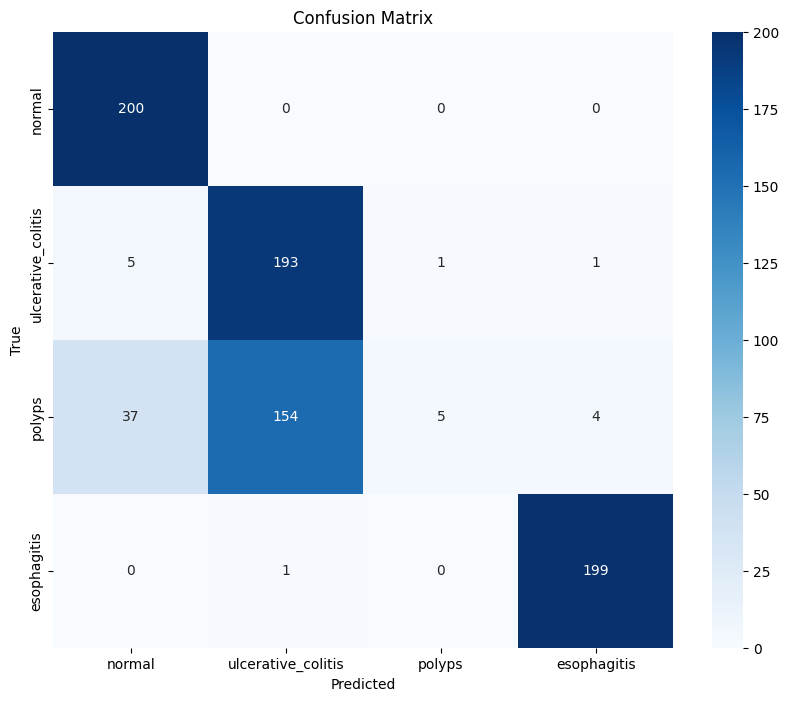

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']  # Replace with your actual class names


def plot_confusion_matrix(model, test_loader, class_names):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(classical_model, test_loader, class_names)

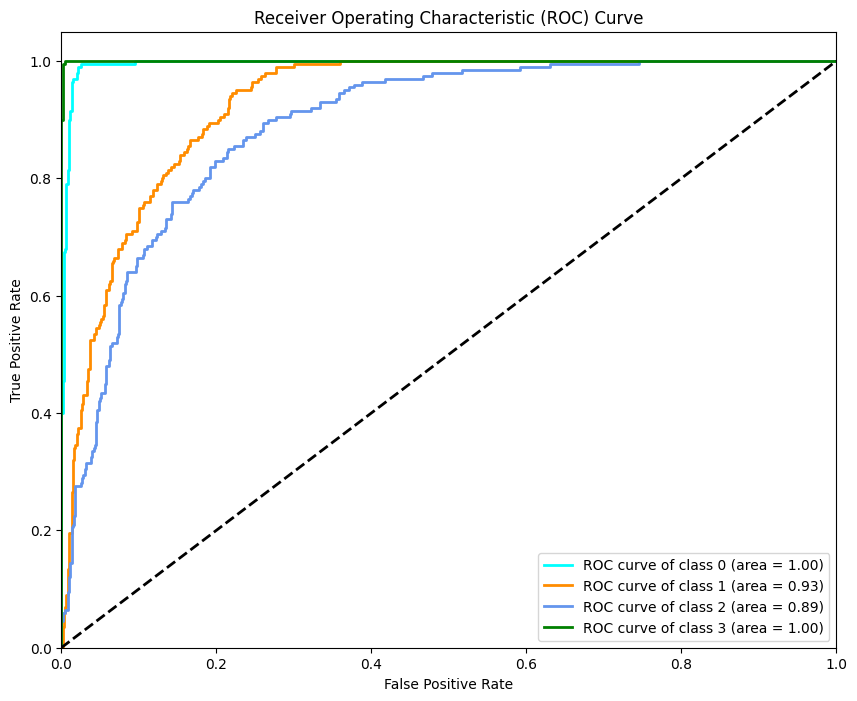

In [65]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(model, test_loader, num_classes):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_score.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    y_true = np.eye(num_classes)[y_true]
    y_score = np.array(y_score)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(classical_model, test_loader, num_classes)

## Quantum Resnet 

In [23]:
# Quantum layer
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [41]:
class QuantumResNet50(nn.Module):
    def __init__(self, num_classes, freeze_layers=True):
        super(QuantumResNet50, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        n_features = self.base_model.fc.in_features  # ResNet50 output features
        self.base_model.fc = nn.Identity()  # Remove the original classification layer

        # Optionally freeze layers
        if freeze_layers:
            for param in self.base_model.parameters():
                param.requires_grad = False

        self.quantum_layer = QuantumLayer(n_qubits=n_qubits, n_features=n_features)
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(n_qubits),
            nn.Linear(n_qubits, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.quantum_layer(x)
        x = self.classifier(x)
        return x



In [42]:
# Initialize the quantum model
num_classes = len(train_dataset.classes)
quantum_model = QuantumResNet50(num_classes).cuda()

# Set up optimizer and loss function for quantum model
q_optimizer = optim.Adam(quantum_model.parameters(), lr=0.001)
q_criterion = nn.CrossEntropyLoss()

In [43]:
# Print the model summary
summary(quantum_model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [47]:
def quantum_train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    device = next(model.parameters()).device
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        
        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
    # Save the model
    torch.save(model.state_dict(), 'quantum_resnet_model.pth')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the quantum model
quantum_results = quantum_train_model(quantum_model, train_loader, val_loader, q_criterion, q_optimizer)

Epoch 1/10
Training Loss: 0.8716, Training Accuracy: 0.7041
Validation Loss: 0.5357, Validation Accuracy: 0.7845
Epoch 2/10
Training Loss: 0.4113, Training Accuracy: 0.8469
Validation Loss: 0.3900, Validation Accuracy: 0.8510
Epoch 3/10
Training Loss: 0.3720, Training Accuracy: 0.8697
Validation Loss: 0.3590, Validation Accuracy: 0.8615
Epoch 4/10
Training Loss: 0.3883, Training Accuracy: 0.8650
Validation Loss: 0.2475, Validation Accuracy: 0.9025
Epoch 5/10
Training Loss: 0.2920, Training Accuracy: 0.9087
Validation Loss: 0.8536, Validation Accuracy: 0.7205
EarlyStopping counter: 1 out of 5
Epoch 6/10
Training Loss: 0.2674, Training Accuracy: 0.9113
Validation Loss: 0.2470, Validation Accuracy: 0.9105
Epoch 7/10
Training Loss: 0.3771, Training Accuracy: 0.8712
Validation Loss: 0.3274, Validation Accuracy: 0.8765
EarlyStopping counter: 1 out of 5
Epoch 8/10
Training Loss: 0.2121, Training Accuracy: 0.9316
Validation Loss: 0.6735, Validation Accuracy: 0.7470
EarlyStopping counter: 2 out

In [48]:
evaluate_model(quantum_model, test_loader, criterion)

Test Loss: 0.3253, Test Accuracy: 0.8738


(0.3252682493813336, tensor(0.8738, device='cuda:0', dtype=torch.float64))

In [59]:
# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
quantum_saved_model = QuantumResNet50(num_classes)
quantum_saved_model.load_state_dict(torch.load('quantum_resnet_model.pth'))
quantum_saved_model.to(device)


QuantumResNet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [60]:
evaluate_model(quantum_saved_model, test_loader, criterion)

Test Loss: 0.3294, Test Accuracy: 0.8738


(0.3294362957961857, tensor(0.8738, device='cuda:0', dtype=torch.float64))

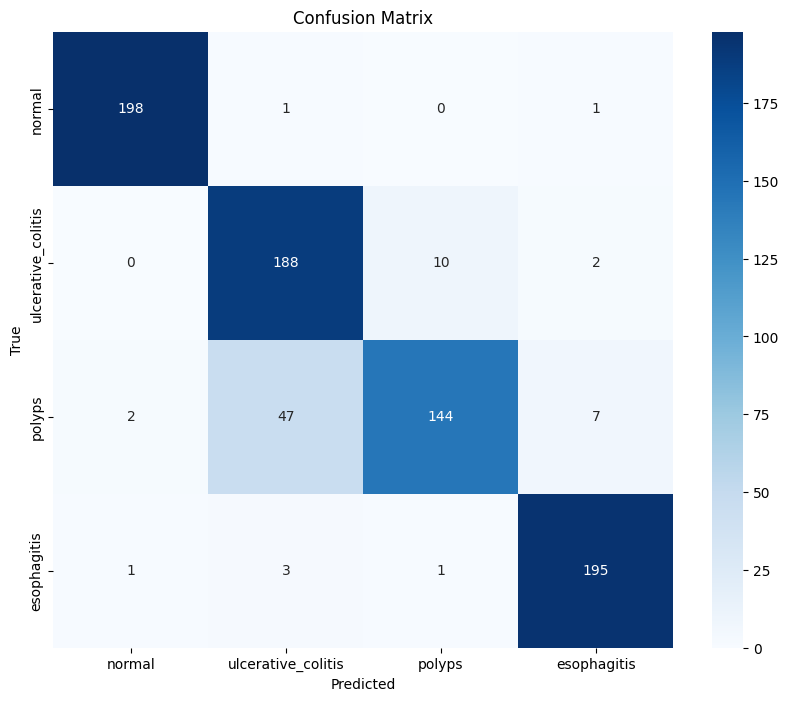

In [62]:
plot_confusion_matrix(quantum_saved_model, test_loader, class_names)

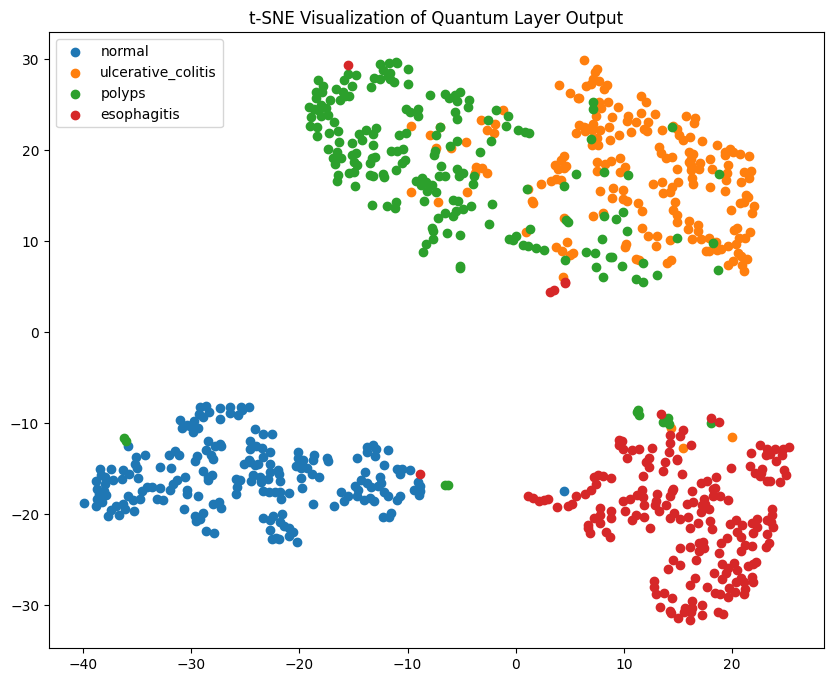

In [64]:
from sklearn.manifold import TSNE

def plot_tsne(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            quantum_outputs = model.quantum_layer(model.base_model(inputs))
            features.extend(quantum_outputs.cpu().numpy())
            labels.extend(targets.numpy())
    
    features = np.array(features)
    labels = np.array(labels)
    
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        idx = labels == i
        plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], label=class_names[i])
    plt.legend()
    plt.title('t-SNE Visualization of Quantum Layer Output')
    plt.show()

plot_tsne(quantum_saved_model, test_loader)

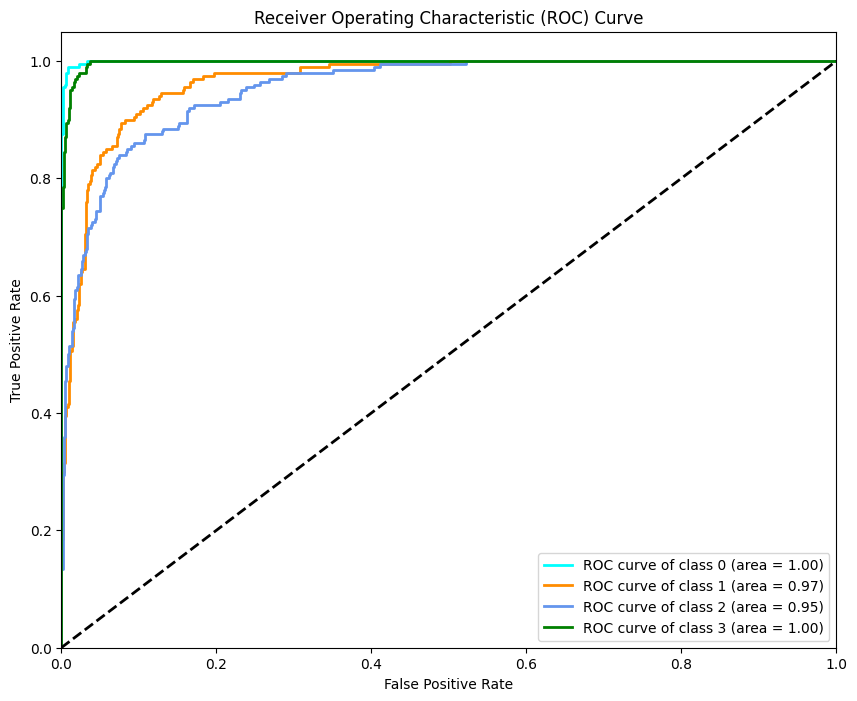

In [66]:
plot_roc_curve(quantum_saved_model, test_loader, num_classes)